In [1]:
import tensorflow as tf

# Limit the number of threads TensorFlow will use
config = tf.config.threading.set_intra_op_parallelism_threads(500)  
config = tf.config.threading.set_inter_op_parallelism_threads(500)  

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

                     Date Type  Symbol                     Company Name  \
0     2014-Feb-2014-02-04  REG  'HUBC'     'Hub Power Company Limited.'   
1     2014-Feb-2014-02-06  REG  'HUBC'     'Hub Power Company Limited.'   
2     2014-Feb-2014-02-07  REG  'HUBC'     'Hub Power Company Limited.'   
3     2014-Feb-2014-02-10  REG  'HUBC'     'Hub Power Company Limited.'   
4     2014-Feb-2014-02-11  REG  'HUBC'     'Hub Power Company Limited.'   
...                   ...  ...     ...                              ...   
2442  2023-Dec-2023-12-22  REG  'HUBC'  'The Hub Power Company Limited'   
2443  2023-Dec-2023-12-26  REG  'HUBC'  'The Hub Power Company Limited'   
2444  2023-Dec-2023-12-27  REG  'HUBC'  'The Hub Power Company Limited'   
2445  2023-Dec-2023-12-28  REG  'HUBC'  'The Hub Power Company Limited'   
2446  2023-Dec-2023-12-29  REG  'HUBC'  'The Hub Power Company Limited'   

       Volume  High Price  Low Price  Closing Price  
0     'READY'     66.6120    60.2680         

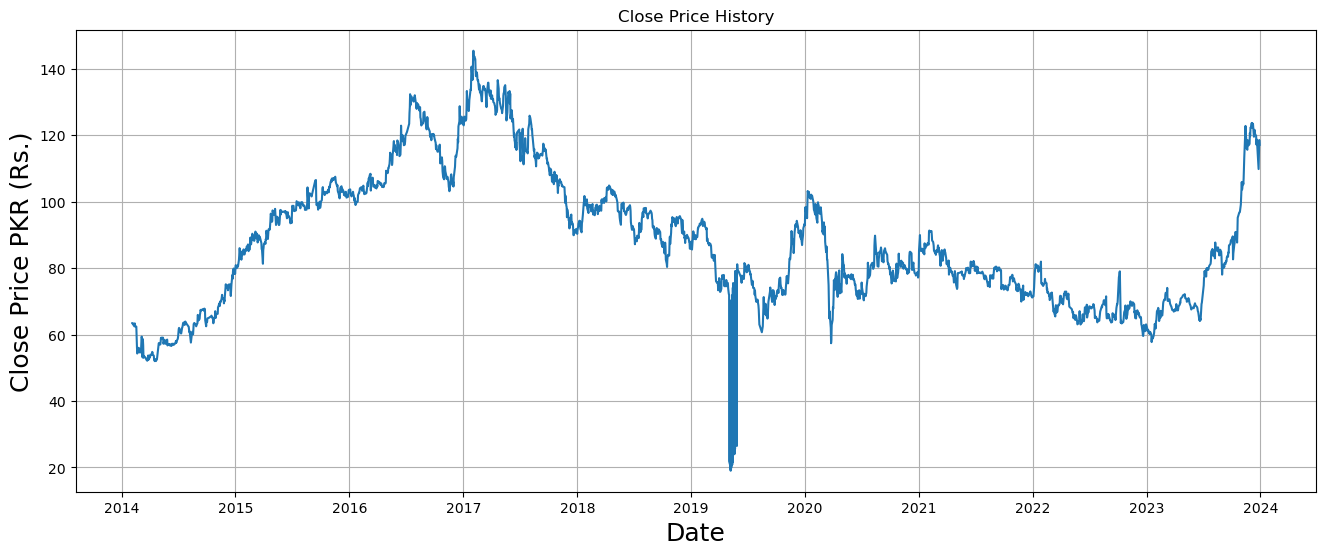

Training Data Length:  2325
x_train shape: (2265, 60, 1)
y_train shape: (2265,)
x_test shape: (122, 60, 1)
y_test shape: (122,)


In [2]:
# Load the CSV file
stock='hubc'
file_path = stock + '_data.csv'
df = pd.read_csv(file_path)

# Display the first few rows
print(df)
df['Date'] = df['Date'].str.slice(start=9)
df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Closing Price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price PKR (Rs.)', fontsize=18)
plt.grid(True)

plt.show()


data = df.filter(['Closing Price'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

print("Training Data Length: ",training_data_len)

# Get the 'Closing Price' column
data = df.filter(['Closing Price'])
dataset = data.values  # Convert the dataframe to a numpy array

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Set the training data length (95% of the dataset)
training_data_len = int(np.ceil(len(dataset) * .95))

# Split the data into training and testing sets
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]  # Include previous 60 time steps for testing

# Prepare the x_train and y_train data
x_train, y_train = [], []

# Create sequences for x_train and corresponding values for y_train
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])  # 60 previous time steps
    y_train.append(train_data[i, 0])  # The next value

# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to be 3D (samples, time_steps, features) for LSTM
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")


x_test, y_test = [], []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])  # 60 previous time steps
    y_test.append(test_data[i, 0])  # The next value

# Convert x_test and y_test to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape x_test to be 3D (samples, time_steps, features) for LSTM
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

In [3]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Reduce learning rate on plateau
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001)

# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=1000, callbacks=[lr_scheduler], workers=8, use_multiprocessing=True)

2024-11-22 12:58:49.332334: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-22 12:58:49.332369: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-22 12:58:49.332376: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-22 12:58:49.332406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 12:58:49.332435: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/1000


2024-11-22 12:58:51.205439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-22 12:58:51.432289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-22 12:58:51.508271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-22 12:58:51.595636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-22 12:58:51.771692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-22 12:58:51.897261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 3/36 [=>............................] - ETA: 1s - loss: 0.1453  

2024-11-22 12:58:52.011959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 4s 61ms/step - loss: 0.0237 - lr: 0.0010
Epoch 2/1000
36/36 [==============================] - 1s 37ms/step - loss: 0.0035 - lr: 0.0010
Epoch 3/1000
36/36 [==============================] - 1s 38ms/step - loss: 0.0023 - lr: 0.0010
Epoch 4/1000
36/36 [==============================] - 1s 39ms/step - loss: 0.0020 - lr: 0.0010
Epoch 5/1000
36/36 [==============================] - 1s 37ms/step - loss: 0.0019 - lr: 0.0010
Epoch 6/1000
36/36 [==============================] - 1s 37ms/step - loss: 0.0017 - lr: 0.0010
Epoch 7/1000
36/36 [==============================] - 1s 40ms/step - loss: 0.0017 - lr: 0.0010
Epoch 8/1000
36/36 [==============================] - 1s 41ms/step - loss: 0.0017 - lr: 0.0010
Epoch 9/1000
36/36 [==============================] - 1s 39ms/step - loss: 0.0015 - lr: 0.0010
Epoch 10/1000
36/36 [==============================] - 1s 38ms/step - loss: 0.0015 - lr: 0.0010
Epoch 11/1000
36/36 [==============================] - 1s 38ms

In [4]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test = y_test.reshape(-1, 1)  # Reshape for inverse_transform compatibility
y_test = scaler.inverse_transform(y_test)

2024-11-22 13:51:45.720079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-22 13:51:46.018569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-22 13:51:46.167365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 5s

2024-11-22 13:51:46.296254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 51ms/step


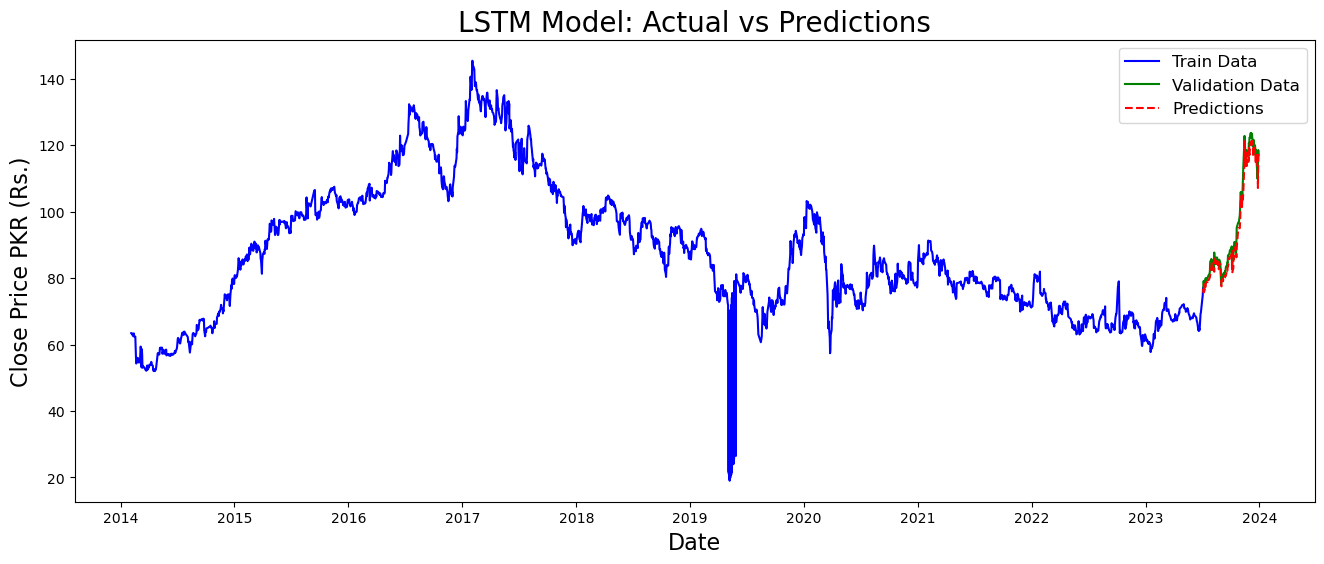

            Closing Price  Predictions
Date                                  
2023-07-05          77.28    76.838486
2023-07-06          79.15    75.660126
2023-07-07          77.74    78.155861
2023-07-10          77.70    76.260216
2023-07-11          77.47    76.446198
2023-07-12          79.91    76.463470
2023-07-13          79.53    78.607384
2023-07-14          79.94    78.895142
2023-07-17          79.47    78.776093
2023-07-18          79.62    78.730827
Total Predictions: 122
Correct Predictions ±5%: 115 (94.26%)


In [5]:
# Create the 'valid' DataFrame with predictions
valid = df[training_data_len:].copy()  # Create a copy of the validation data
valid['Predictions'] = predictions  # Add predictions to 'valid'

# Plot the data
plt.figure(figsize=(16, 6))
plt.title('LSTM Model: Actual vs Predictions', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price PKR (Rs.)', fontsize=16)

# Plot the training data, validation data, and predictions
plt.plot(df['Closing Price'][:training_data_len], label='Train Data', color='blue')  # Plot train data
plt.plot(valid['Closing Price'], label='Validation Data', color='green')  # Plot validation data
plt.plot(valid['Predictions'], label='Predictions', color='red', linestyle='--')  # Plot predictions

plt.legend(loc='upper right', fontsize=12)
plt.show()

# Display a portion of the 'valid' table for comparison
print(valid[['Closing Price', 'Predictions']].head(10))  # Show first 10 rows of 'valid'


# Calculate the percentage difference between actual and predicted values
valid['Difference'] = np.abs((valid['Closing Price'] - valid['Predictions']) / valid['Closing Price']) * 100

# Categorize predictions based on different percentage differences
valid['Prediction Correct ±1%'] = valid['Difference'] <= 1
valid['Prediction Correct ±2%'] = valid['Difference'] <= 2
valid['Prediction Correct ±5%'] = valid['Difference'] <= 5

# Calculate the total number of predictions, correct predictions, and incorrect predictions for each condition
total_predictions = len(valid)
correct_predictions_1 = valid['Prediction Correct ±1%'].sum()
correct_predictions_2 = valid['Prediction Correct ±2%'].sum()
correct_predictions_5 = valid['Prediction Correct ±5%'].sum()

incorrect_predictions_1 = total_predictions - correct_predictions_1
incorrect_predictions_2 = total_predictions - correct_predictions_2
incorrect_predictions_5 = total_predictions - correct_predictions_5

# Calculate accuracies for ±1%, ±2%, and ±5%
accuracy_1 = (correct_predictions_1 / total_predictions) * 100  # ±1% accuracy
accuracy_2 = (correct_predictions_2 / total_predictions) * 100  # ±2% accuracy
accuracy_5 = (correct_predictions_5 / total_predictions) * 100  # ±5% accuracy

# Output the results
print(f'Total Predictions: {total_predictions}')
# print(f'Correct Predictions ±1%: {correct_predictions_1} ({accuracy_1:.2f}%)')
# print(f'Correct Predictions ±2%: {correct_predictions_2} ({accuracy_2:.2f}%)')
print(f'Correct Predictions ±5%: {correct_predictions_5} ({accuracy_5:.2f}%)')

# Save the results to a CSV file
validity_filename = stock + '_valid_predictions.csv'
valid.to_csv(validity_filename, columns=['Closing Price', 'Predictions', 'Difference', 'Prediction Correct ±1%', 'Prediction Correct ±2%', 'Prediction Correct ±5%'])

In [6]:
rmse = np.sqrt(mean_squared_error(valid['Closing Price'], valid['Predictions']))
print(f"RMSE: {rmse}")

RMSE: 2.7154951310729536


1/1 [==============================] - 0s 33ms/step
            Predicted Close Price
2023-12-30             113.917664
2023-12-31             111.249779
2024-01-01             108.819870
2024-01-02             106.661346
2024-01-03             104.810425
...                           ...
2024-04-23              60.985229
2024-04-24              60.957218
2024-04-25              60.930004
2024-04-26              60.903549
2024-04-27              60.877823

[120 rows x 1 columns]


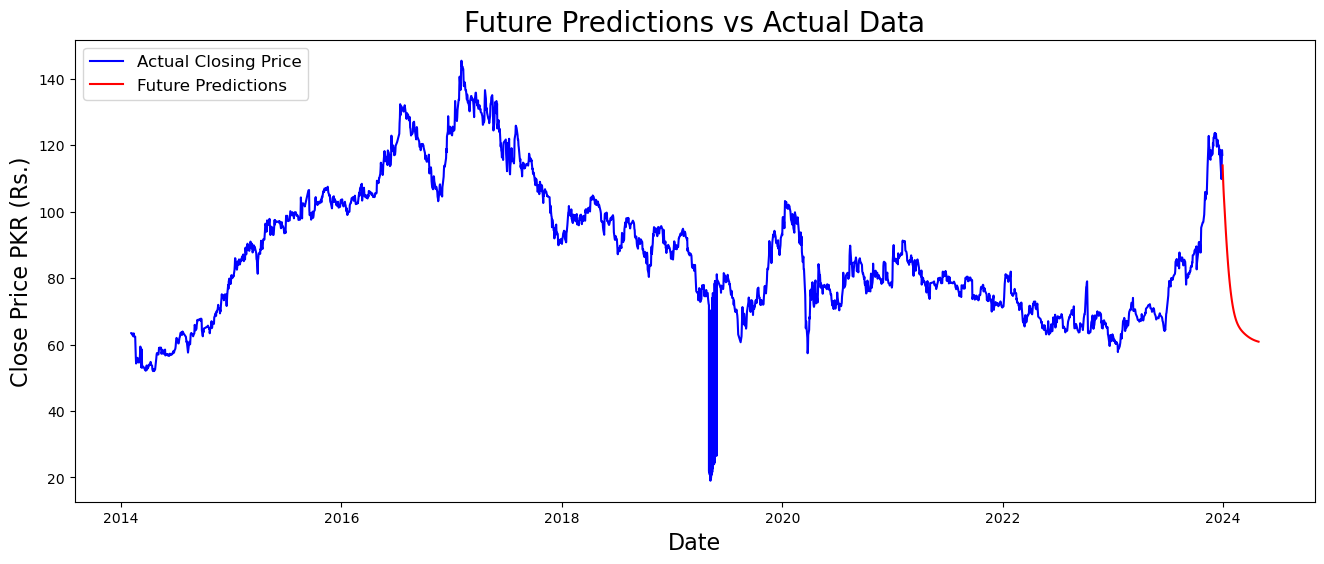

In [7]:
# Number of days/weeks/months you want to predict into the future
future_steps = 120  # Adjust as needed (e.g., 30 days into the future)

# Use the last 60 values from the training data to start the prediction
input_sequence = scaled_data[-60:]  # Use the last 60 scaled values
input_sequence = input_sequence.reshape((1, 60, 1))  # Reshape for LSTM input

# Prepare an empty list to store the future predictions
future_predictions = []

# Make future predictions iteratively
for _ in range(future_steps):
    # Predict the next value
    prediction = model.predict(input_sequence)
    
    # Append the prediction to the list of future predictions
    future_predictions.append(prediction[0][0])
    
    # Update the input sequence for the next prediction
    input_sequence = np.append(input_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Inverse scale the predictions to get the actual values
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate a date range for the future predictions (adjust based on your data's frequency)
last_date = df.index[-1]  # Get the last date in the dataset
date_range = pd.date_range(last_date, periods=future_steps + 1, freq='D')[1:]  # Predict next `future_steps` days

# Create a DataFrame for the future predictions
future_df = pd.DataFrame(future_predictions, index=date_range, columns=['Predicted Close Price'])

# Display the future predictions
print(future_df)

# Plot the future predictions
plt.figure(figsize=(16, 6))
plt.title('Future Predictions vs Actual Data', fontsize=20)
plt.plot(df['Closing Price'], label='Actual Closing Price', color='blue')
plt.plot(future_df.index, future_df['Predicted Close Price'], label='Future Predictions', color='red')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price PKR (Rs.)', fontsize=16)
plt.legend(loc='upper left', fontsize=12)
plt.show()


In [8]:
model_name=stock + '_model.keras'
model.save(model_name)